# Pine Labs

In [1]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import pandas as pd
import gensim
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 900
png_renderer.height = 500
pio.renderers.default = "png"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/pine_labs/pine_labs.csv')

In [3]:
# Company username
company_username = 'PineLabs'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [6]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [7]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [9]:
qdf.shape

(511, 28)

In [10]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 468


In [11]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [39]:
result_list = []
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[0]['username'] != company_username:
        response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result_list.append([conversation_id, response_time])

result = pd.DataFrame(result_list, columns=['conversation_id', 'response_time'])

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



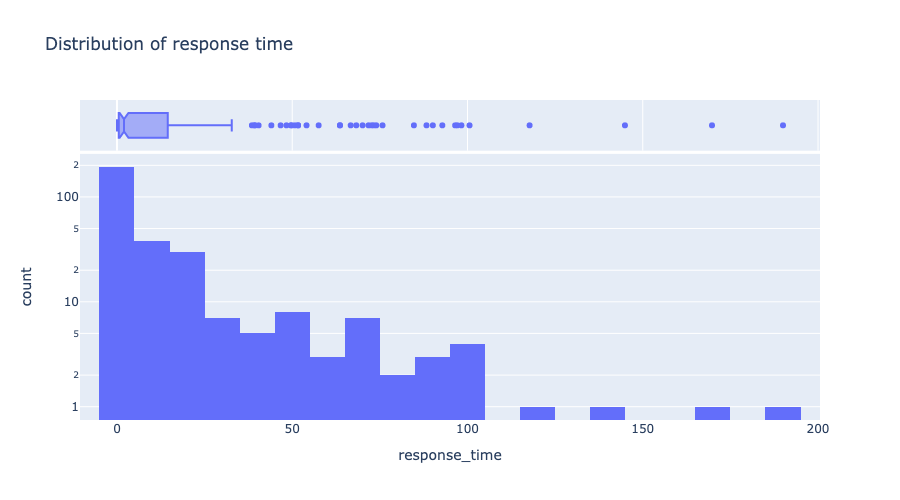

In [40]:
fig = px.histogram(result[result['response_time']<1000], x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [41]:
result['resolution_time'] = 0

In [42]:
unresolved_queries_count = 0
for index, row in result.iterrows():
    tmp = df[df['conversation_id'] == row['conversation_id']]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[0]['username'] != company_username:
        if tmp.iloc[-1]['username'] == company_username:
            resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
            result.at[index, 'resolution_time'] = resolution_time

In [43]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 236
Number of queries unresolved: 68


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



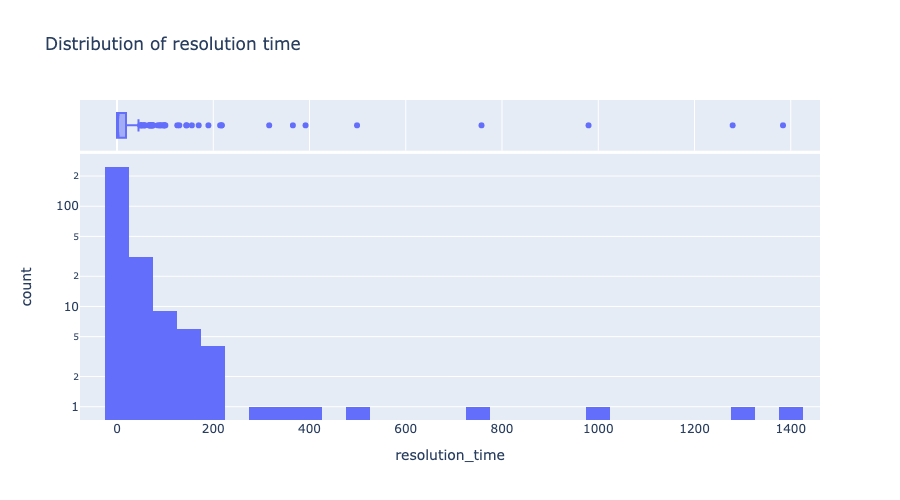

In [45]:
fig = px.histogram(result[result['resolution_time']<2000], x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [20]:
result.describe()

,response_time,resolution_time
count,468.000000,468.000000
mean,11.482594,64.629625
std,62.884684,573.200856
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.442778,0.754444
75%,4.286528,17.082917
max,1279.305278,11950.471389


In [46]:
result.to_csv('./../../../../outputs/time_data/pine_labs.csv', index=False)

## Query Tweets Topics


In [21]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[(queries['inReplyToTweetId'] == 'nan') & (queries['username'] != company_username)]
queries.shape

(299, 28)

In [22]:
processor = Processor('./../../data/config.json')
pre_queries, post_queries = processor.preprocess(queries)
pre_id2word = gensim.corpora.Dictionary(pre_queries['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_queries['bigram'].values.tolist())
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_queries['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_queries['bigram'].values.tolist()]


In [23]:
pre_queries.shape

(73, 31)

In [24]:
post_queries.shape


(209, 31)

In [25]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.6,
                                        eta=0.3)
pre_coherence_model = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_queries['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_model_score = pre_coherence_model.get_coherence()
print('Pre-COVID coherence Score: ', pre_coherence_model_score)

Pre-COVID coherence Score:  -12.721736167240778


In [26]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(pre_lda_model, pre_corpus, pre_id2word)
LDAvis_prepared


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.064878  0.064246       1        1  42.036796
0     -0.094258  0.018445       2        1  36.859281
1      0.029380 -0.082691       3        1  21.103923, topic_info=         Term       Freq      Total Category  logprob  loglift
14   response   8.000000   8.000000  Default  30.0000  30.0000
89    getting   4.000000   4.000000  Default  29.0000  29.0000
199    faulty   2.000000   2.000000  Default  28.0000  28.0000
198    doesnt   2.000000   2.000000  Default  27.0000  27.0000
46        pos  11.000000  11.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
443      poor   1.370026   3.808011   Topic3  -4.9933   0.5334
9     machine   3.218307  24.142221   Topic3  -4.1392  -0.4594
311     debit   0.894383   1.815242   Topic3  -5.4197   0.8479
72   customer   1.335270  10.046122   Topic3  -5.0190  -0.4623
279      work   0.810756   2.526799   Topic3  -5.5179   0.4190

[194 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
23        1  0.410664     able
23        3  0.410664     able
101       1  0.448049  account
101       3  0.448049  account
146       1  0.598181      ago
...     ...       ...      ...
279       3  0.395758     work
54        1  0.497117  working
54        2  0.497117  working
55        1  0.664603    worst
55        2  0.265841    worst

[218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [27]:
pre_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=pre_lda_model, 
                                                         corpus=pre_corpus, 
                                                         texts=pre_queries['bigram'].values.tolist(),
                                                         tweets=pre_queries['tweet'].values.tolist())

In [28]:
pre_queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['machine, response, pos, service, customer, pinelab, swipe, shame, machines, ct_ct',
       'payment, machine, service, machines, getting, pos, know, help, faulty, month',
       'machine, customer, worst, company, need, help, service, services, month, payment'],
      dtype=object)

Following topics were discussed pre-COVID:
1. POS machine not working as expected
2. No follows
3. Issues related to payments

In [29]:
select = pre_queries_topic_sents_keywords['Topic_Keywords'].unique()[2]
pre_queries_topic_sents_keywords[pre_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

array(["@PineLabs worst service ever in finance sector. From the day of its installation, it's pos machine is not working properly and tired of calling your peoples in Jharkhand. Business is suffering a lot and I become stupid by paying advance rental. https://t.co/4ZnJGVQS0V",
       '@PineLabs applied for swiping machine and it was promised to get on 17th, but now your team is requesting for one more week. Can u pl help to expedite this?',
       '@EOWDelhi @PunePolice Dear authorities we have informed Pine Labs Private Limited to discontinue services and stop use of ECS mandate to our account. How can we file FIR in this regard. @PineLabs is not responding. Pls guide. #pinelabs',
       '@PineLabs i m from tunmarg aircon Indore(M P) my swipe machine is not working from last three month ur sumeet makwana 📱9907650650 know that but no one give resolution &amp; rental deduct every month why ?\nJust take machine &amp; give my payment back \nCall back ASAP\n9827788674\n9036699339',
      

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



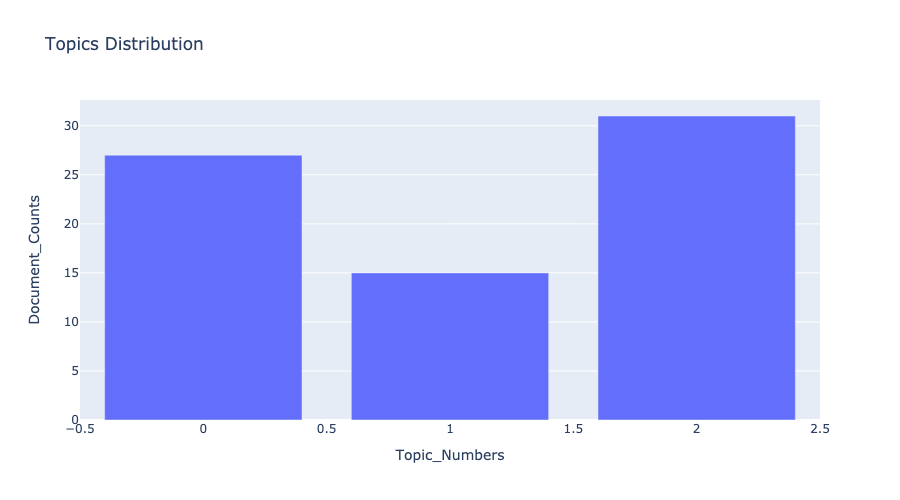

In [30]:
pre_queries_dist, fig = processor.plot_topic_distribution(pre_queries_topic_sents_keywords)
fig.show()

In [31]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')
post_coherence_model = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_queries['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_model_score = post_coherence_model.get_coherence()
print('Post-COVID coherence Score: ', post_coherence_model_score)

Post-COVID coherence Score:  -8.884380360706308


In [32]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(post_lda_model, post_corpus, post_id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.106420 -0.021604       1        1  28.299542
1     -0.051427 -0.091350       2        1  26.303893
2     -0.057501  0.044694       3        1  26.246920
3      0.002508  0.068261       4        1  19.149646, topic_info=              Term       Freq      Total Category  logprob  loglift
252           time  11.000000  11.000000  Default  30.0000  30.0000
25           sales  14.000000  14.000000  Default  29.0000  29.0000
241       deducted   6.000000   6.000000  Default  28.0000  28.0000
330    transaction  15.000000  15.000000  Default  27.0000  27.0000
366             th   9.000000   9.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
230           team   2.543713  27.647868   Topic4  -5.3089  -0.7330
50        received   2.359035  15.970280   Topic4  -5.3843  -0.2596
13         working   2.324939  15.234976   Topic4  -5.3989  -0.2270
3    customer_care   2.222255  10.833023   Topic4  -5.4440   0.0688
276           rent   2.196861   7.868363   Topic4  -5.4555   0.3771

[280 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
18        1  0.344191       able
18        2  0.516286       able
18        4  0.172095       able
630       2  0.914008  accepting
193       1  0.361712    account
...     ...       ...        ...
58        4  0.966665      worse
29        1  0.221019      worst
29        2  0.331528      worst
29        3  0.276273      worst
29        4  0.165764      worst

[401 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [33]:
post_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=post_lda_model, 
                                                         corpus=post_corpus, 
                                                         texts=post_queries['bigram'].values.tolist(),
                                                         tweets=post_queries['tweet'].values.tolist())

In [34]:
post_queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['service, days, dont, transaction, money, payment, customer, working, epos, received',
       'machine, time, payment, pos, sales, service, ur, deducted, customer, card',
       'machine, team, issue, service, days, worst, bank, months, card, company',
       'service, machine, team, days, months, response, th, support, month, refund'],
      dtype=object)

Following topics were discussed post pandemic:
1. Poor functioning of POS
2. Settlement/refund issues and POS charges
3. Issues related to accounts
4. No action issues

In [35]:
# select = post_queries_topic_sents_keywords['Topic_Keywords'].unique()[3]
# post_queries_topic_sents_keywords[post_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



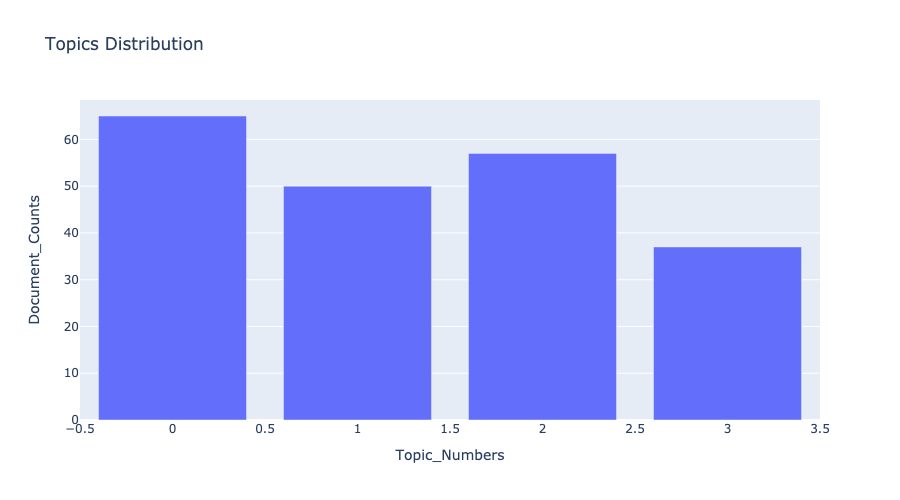

In [36]:
post_queries_dist, fig = processor.plot_topic_distribution(post_queries_topic_sents_keywords)
fig.show()

In [37]:
pre_queries_dist

,Topic_Numbers,Document_Counts
0,2,31
1,0,27
2,1,15


In [38]:
post_queries_dist

,Topic_Numbers,Document_Counts
0,0,65
1,2,57
2,1,50
3,3,37
